In [1]:
import tensorflow as tf
import numpy as np
import shutil
import os

## The ODE example

The ODE equation is:

$$\frac{d\Psi}{dx}+(x+\frac{1+3x^2}{1+x+x^3})\Psi=x^3+2x+x^2\frac{1+3x^2}{1+x+x^3}$$

With the following condition:
$$\Psi(0) = 1\quad and \quad x \in [0,1]$$

The trial neural form of the solution which satisflies the constraints above is assumed to be:

$$\Psi_{t}(x) = 1+xN(x,\vec{p})$$

Where $N(x,\vec{p})$ is the output of the neural network, $\vec{p}$ are the parameters of the neural network.

The analytic solution is:
    
$$\Psi_{a}(x) = \frac{e^{-x^2}/2}{1+x+x^3}$$

## Function for the ODE

In [2]:
def trial_neural_form_solution(x, network_output):
    
    return 1. + x * network_output


def d_Psi_from_eq(x, network_output):
    
    Psi_network = trial_neural_form_solution(x, network_output)
    
    LHS = x + (1. + 3.*x**2) / (1. + x + x**3)
    RHS = x**3 + 2.*x + x**2 * ((1. + 3.*x**2) / (1. + x + x**3))
    
    d_Psi = RHS - Psi_network*LHS
    
    return d_Psi


def d_Psi_from_cal(x, network_output):
    
    d_network_output = tf.gradients(network_output, x)

    d_Psi = network_output + x * d_network_output
    
    return d_Psi

    
def analytic_sol(x):
    '''
        Analytical solution of current problem
    '''
    return (np.exp((-x**2)/2.)) / (1. + x + x**3) + x**2




## Prepare input data and analytic solution

In [3]:
nx_train = 20
nx_predict = 10

x_inputs = np.linspace(0, 1, nx_train)
x_predict = np.linspace(0, 1, nx_predict)
psi_analytic = analytic_sol(x_predict)

x_inputs = x_inputs.reshape(x_inputs.shape[0],-1)
x_predict = x_predict.reshape(x_predict.shape[0],-1)
psi_analytic = psi_analytic.reshape(psi_analytic.shape[0],-1)

## Build the neural network

In [4]:
# Parameters
learning_rate = 0.005
num_steps = 500
display_step = 100
 
# Network Parameters
n_hidden_1 = 20 # 1st layer number of neurons
n_hidden_2 = 10 # 2nd layer number of neurons
num_input = 1   # number of input neurons 
num_output = 1  # number of output neurons 

In [5]:
# input variable
X = tf.placeholder("float", [None, num_input], name="input")

In [6]:
# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([num_input, n_hidden_1])),
    'out': tf.Variable(tf.random_normal([n_hidden_1, num_output]))
}

biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'out': tf.Variable(tf.random_normal([num_output]))
}

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
# Create a flow for network model
def neural_net(x):
  
    # Hidden fully connected layer with 256 neurons
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.sigmoid(layer_1)
    
    # Output fully connected layer with a neuron for each class
    outputs = tf.matmul(layer_1, weights['out']) + biases['out']
    
    return outputs

In [8]:
# Define feed forward flow
network_output = neural_net(X)

In [9]:
# Define loss and optimizer
Psi_network = trial_neural_form_solution(X, network_output)
Psi_network = tf.identity(Psi_network, name="predict_output")

d_Psi_from_eq_val = d_Psi_from_eq(X, network_output)
d_Psi_from_cal_val = d_Psi_from_cal(X, network_output)

with tf.name_scope('Loss'):
    loss_op = tf.reduce_sum(tf.square(d_Psi_from_eq_val - d_Psi_from_cal_val))
    
with tf.name_scope('Train'):
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
    train_op = optimizer.minimize(loss_op)

Instructions for updating:
Use tf.cast instead.


In [10]:
# Check the file path for saving the model
folderpath = "./tmp/model"
filepath = folderpath+"/test_model"

if os.path.exists(folderpath):
    shutil.rmtree(folderpath)
    
os.makedirs(folderpath)    

In [11]:
# Start training

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

# create saver object
saver = tf.train.Saver()


with tf.Session() as sess:
 
    # Run the initializer
    sess.run(init)
 
    for step in range(1, num_steps+1):

        # Run optimization op (backprop)
        sess.run(train_op, feed_dict={X: x_inputs})
        
        if step % display_step == 0 or step == 1:
            # Calculate batch loss and accuracy
            loss = sess.run(loss_op, feed_dict={X: x_inputs})
            
            print ("Step " + str(step) + ", Loss = " + "{:.4f}".format(loss) )

    print ("Training Finished!")
    
    # save model     
    save_path = saver.save(sess, filepath)
    print("Model saved in file: %s" % save_path)

Step 1, Loss = 643.7175
Step 100, Loss = 7.6231
Step 200, Loss = 4.0318
Step 300, Loss = 1.6950
Step 400, Loss = 0.6124
Step 500, Loss = 0.2414
Training Finished!
Model saved in file: ./tmp/model/test_model


## Restore the model and predict

In [12]:
tf.reset_default_graph()

with tf.Session() as sess:

    # 使用 import_meta_graph 載入計算圖
    saver = tf.train.import_meta_graph(filepath+".meta")
    saver.restore(sess, tf.train.latest_checkpoint(folderpath))
    
    graph = tf.get_default_graph()
    
    input_again = graph.get_tensor_by_name('input:0')
    ouput_again = graph.get_tensor_by_name('predict_output:0')

    psi_predict_network = sess.run(ouput_again, feed_dict = {input_again: x_predict})

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./tmp/model\test_model


## Plot the result

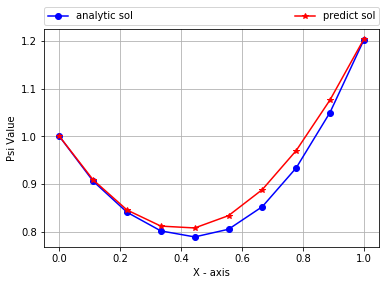

In [14]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots()

ax.plot(x_predict, psi_analytic, 'bo-', label="analytic sol") 
ax.plot(x_predict, psi_predict_network, 'r*-', label="predict sol")

ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)

ax.set_ylabel('Psi Value')
ax.set_xlabel('X - axis')
ax.grid()
plt.savefig('ANN_for_ODE.png')
plt.show()